Problem Statement : Build a model to predict Emotion from Audio clip 

Solution approach : convert audio into MFCC(Mel-frequency cepstral coefficients) which is short term power spectrum of sound . It can be used for automatic speech and speaker recognition. However here we're not going to map MFCC with pre-labeled emotions and train a CNN-LSTM model to capture that mapping & use that for predicting new custom audio


 
 Dataset link :
 
https://www.kaggle.com/datasets/ejlok1/cremad

https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio

https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess

https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee

In [1]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict,Counter
import os,glob,pickle
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential, Model, model_from_json
from keras.utils import np_utils, to_categorical,plot_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [3]:
TESS = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
RAV = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
SAVEE = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"
CREMA = "/kaggle/input/cremad/AudioWAV/"


### TESS 

In [4]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

['OAF_Fear',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'OAF_angry',
 'OAF_disgust',
 'OAF_happy',
 'OAF_neutral',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

Dataset is from 2 speakers -> young female(YAF_),older female(OAF_) each having 7 classes
                                    so it's female dominant dataset
                                    
        anger
        disgust
        fear
        happiness
        pleasant surprise
        sadness
        neutral

compared to other dataset it has a new category "pleasant surprise". For now let's assume this is same as "surprise" from other dataframe

In [5]:
path=[]
emotion=[]
for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('female_angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('female_disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('female_fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('female_happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('female_neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('female_surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('female_sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)
        
TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.labels.value_counts()

female_fear        400
female_surprise    400
female_sad         400
female_angry       400
female_disgust     400
female_happy       400
female_neutral     400
Name: labels, dtype: int64

## RAVDESS

In [6]:
dir_list = os.listdir(RAV)
dir_list.sort()
dir_list

['Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23',
 'Actor_24']

Dataset has 24 actors of different genders, filenames follow below convention

    Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
    Vocal channel (01 = speech, 02 = song).
    Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
    Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
    Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
    Repetition (01 = 1st repetition, 02 = 2nd repetition).
    Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

For an audio filename -> 02-01-06-01-02-01-12.mp4

    Video-only (02)
    Speech (01)
    Fearful (06)
    Normal intensity (01)
    Statement "dogs" (02)
    1st Repetition (01)
    12th Actor (12) - Female (as the actor ID number is even)

Male & Female speaker has to be trained separately -> female has a higher pitch that male,
so tagging the gender along with emotion is important , cobining "calm"+"neutral" into "neutral" frame -> we've done something similar with "pleasant surprise" in TESS dataframe

In [7]:
emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

male_neutral       144
female_neutral     144
male_sad            96
male_fear           96
male_happy          96
male_disgust        96
male_angry          96
male_surprise       96
female_surprise     96
female_disgust      96
female_fear         96
female_sad          96
female_happy        96
female_angry        96
Name: labels, dtype: int64

## SAVEE

In [8]:
dir_list = os.listdir(SAVEE)
dir_list.sort()

res = defaultdict(list)
for i in dir_list:
    res[i[0:3]].append(i)

print(str(list(res.values())[0][1]))
print(str(list(res.values())[1][1]))
print(str(list(res.values())[2][1]))
print(str(list(res.values())[3][1]))

DC_a02.wav
JE_a02.wav
JK_a02.wav
KL_a02.wav


Filenames follow this abbreviation for emotion classes

    'a' = 'anger'
    'd' = 'disgust'
    'f' = 'fear'
    'h' = 'happiness'
    'n' = 'neutral'
    'sa' = 'sadness'
    'su' = 'surprise' 
    
This is male heavy dataset , this dataset has records from 4 native English male speakers (DC, JE, JK, KL) age group 27~31

In [9]:
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error') 
    path.append(SAVEE + i)
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.labels.value_counts()

male_neutral     120
male_angry        60
male_disgust      60
male_fear         60
male_happy        60
male_sad          60
male_surprise     60
Name: labels, dtype: int64

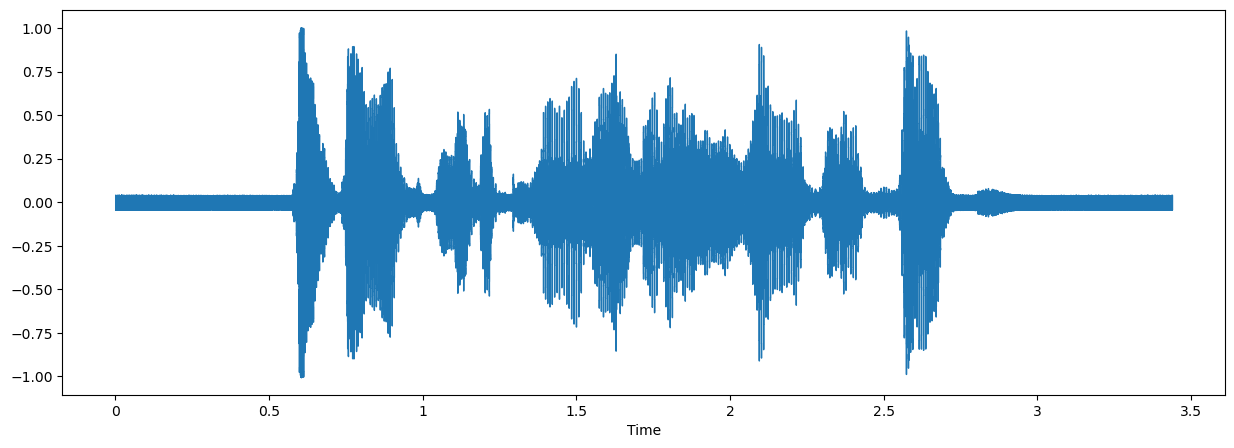

In [10]:
fname = SAVEE + 'DC_a02.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)
Audio(fname)

## CREMA-D

In [11]:
dir_list = os.listdir(CREMA)
dir_list.sort()

res = defaultdict(list)
for i in dir_list:
    res[i[9:12]].append(i)

print(str(list(res.values())[0][0]))
print(str(list(res.values())[1][0]))
print(str(list(res.values())[2][0]))
print(str(list(res.values())[3][0]))
print(str(list(res.values())[4][0]))
print(str(list(res.values())[5][0]))


1001_DFA_ANG_XX.wav
1001_DFA_DIS_XX.wav
1001_DFA_FEA_XX.wav
1001_DFA_HAP_XX.wav
1001_DFA_NEU_XX.wav
1001_DFA_SAD_XX.wav


Dataset contains differnt speakers & intensities of emotion from movies. It's missing "surprise" emotion. Here gender information is in a separated csv file which maps to actors

In [12]:
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)
    
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()


male_angry        671
male_disgust      671
male_fear         671
male_happy        671
male_sad          671
female_angry      600
female_disgust    600
female_fear       600
female_happy      600
female_sad        600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

In [13]:
df = pd.concat([SAVEE_df, RAV_df, TESS_df, CREMA_df], axis = 0)
print(df.labels.value_counts())
df.head()
df.to_csv("Data_path.csv",index=False)

female_disgust     1096
female_fear        1096
female_sad         1096
female_happy       1096
female_angry       1096
female_neutral     1056
male_neutral        839
male_angry          827
male_disgust        827
male_fear           827
male_happy          827
male_sad            827
female_surprise     496
male_surprise       156
Name: labels, dtype: int64


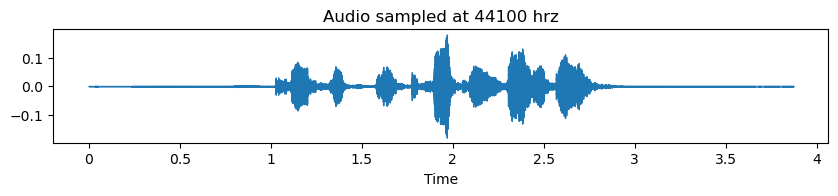

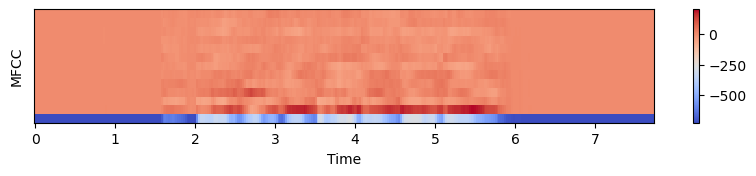

In [14]:
## RAVDESS : Male(01)-Angry(05)
path = "/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-05-01-01-01-01.wav"
X, sample_rate = librosa.load(path,sr=44100)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(10,5))
plt.subplot(3,1,1)
librosa.display.waveshow(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(10,5))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

Audio(path)

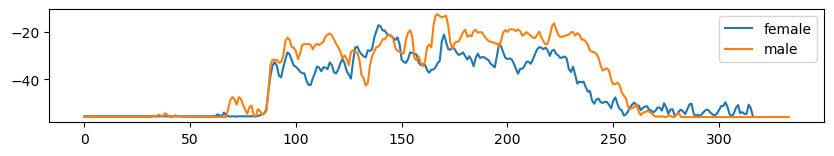

In [15]:
# RAVDESS : Male-Angry ~ Female-Angry

male_path="/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-05-01-01-01-01.wav"
female_path="/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-05-01-01-01-02.wav"

X, sample_rate = librosa.load(male_path,sr=44100)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)

X, sample_rate = librosa.load(female_path,sr=44100)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)


plt.figure(figsize=(10,5))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

In [16]:
data=pd.read_csv("/kaggle/working/Data_path.csv")
data.head()

,labels,source,path
0,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
1,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
2,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
3,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
4,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...


In [17]:
data_labels = data.labels.unique()
data_values = [0]*14
data_count  = dict(zip(data_labels,data_values))
data_count

{'male_angry': 0,
 'male_disgust': 0,
 'male_fear': 0,
 'male_happy': 0,
 'male_neutral': 0,
 'male_sad': 0,
 'male_surprise': 0,
 'female_surprise': 0,
 'female_neutral': 0,
 'female_disgust': 0,
 'female_fear': 0,
 'female_sad': 0,
 'female_happy': 0,
 'female_angry': 0}

In [18]:
#df1=pd.DataFrame(columns=data.columns)

labels_ls=[]
source_ls=[]
path_ls=[]
for idx in tqdm(range(len(data))):
    key=data.iloc[idx,0]
    if data_count.get(key)<=155:
        #df1.append(data.loc[idx],ignore_index=True)
        labels_ls.append(data.iloc[idx,0])
        source_ls.append(data.iloc[idx,1])
        path_ls.append(data.iloc[idx,2])
        data_count[key]=data_count.get(key)+1
        
df1=pd.DataFrame(labels_ls,columns=["labels"])
df1=pd.concat([df1,pd.DataFrame(source_ls,columns=['source'])],axis=1)
df1=pd.concat([df1,pd.DataFrame(path_ls,columns=['path'])],axis=1)
df1.labels.value_counts()

100%|██████████| 12162/12162 [00:00<00:00, 20556.14it/s]


male_angry         156
male_disgust       156
male_fear          156
male_happy         156
male_neutral       156
male_sad           156
male_surprise      156
female_surprise    156
female_neutral     156
female_disgust     156
female_fear        156
female_sad         156
female_happy       156
female_angry       156
Name: labels, dtype: int64

In [19]:
df1.labels.value_counts()

male_angry         156
male_disgust       156
male_fear          156
male_happy         156
male_neutral       156
male_sad           156
male_surprise      156
female_surprise    156
female_neutral     156
female_disgust     156
female_fear        156
female_sad         156
female_happy       156
female_angry       156
Name: labels, dtype: int64

In [20]:
mfcc=pd.DataFrame(columns=["feature"])

for idx in tqdm(range(len(df1))):
    path = df1.loc[idx]["path"]
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=44100)
    sample_rate = np.array(sample_rate) 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate,n_mfcc=13),axis=0)
    mfcc.loc[idx] = [mfccs]


100%|██████████| 2184/2184 [03:55<00:00,  9.28it/s]


In [21]:
df2 = pd.concat([df1,pd.DataFrame(mfcc['feature'].values.tolist())],axis=1)

In [22]:
df2=df2.fillna(0)
df2.to_csv("mfcc_Data_path_2.csv",index=False)
df2.labels.unique()

array(['male_angry', 'male_disgust', 'male_fear', 'male_happy',
       'male_neutral', 'male_sad', 'male_surprise', 'female_surprise',
       'female_neutral', 'female_disgust', 'female_fear', 'female_sad',
       'female_happy', 'female_angry'], dtype=object)

In [23]:
df=pd.read_csv("/kaggle/input/mfcc-datas-2/mfcc_Data_path_2.csv")
df.head()

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-7.158996,-11.374899,-22.261309,-22.644367,-23.342274,-23.716145,-23.493626,...,-20.031172,-13.876329,-8.678366,-7.060525,-6.809310,-7.595342,-9.594822,-12.771606,-10.962038,-8.075041
1,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-8.735627,-12.613672,-21.003633,-22.855877,-23.084211,-22.846296,-21.453540,...,-1.757506,-2.273407,-2.158254,-2.838482,-5.475282,-8.640342,-10.375813,-10.348609,-9.497466,-4.182144
2,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-9.043591,-13.055919,-21.965773,-22.249317,-22.368425,-21.982382,-22.006844,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-8.485731,-12.214720,-24.306343,-24.467314,-24.823780,-25.667818,-26.479832,...,-28.391808,-29.012627,-28.471081,-26.837315,-27.460592,-26.439013,-26.213043,-25.171753,-21.347507,-15.192677
4,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-15.107985,-18.287703,-22.665651,-22.280993,-23.484982,-22.601595,-23.355131,...,-26.672401,-25.695099,-24.581419,-24.849407,-24.308491,-24.677073,-25.551260,-26.462811,-21.861610,-15.606032


In [24]:
X=df.drop(['path','labels','source'],axis=1)
y=df.labels
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,shuffle=True,random_state=42)

In [25]:
sc = StandardScaler()
sc=sc.fit(X_train)
X_train=sc.transform(X_train)
X_test=sc.transform(X_test)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1638, 216), (546, 216), (1638,), (546,))

In [26]:
# X_train = np.array(X_train)
# y_train = np.array(y_train)
# X_test = np.array(X_test)
# y_test = np.array(y_test)

In [27]:
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.transform(y_test))


# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

In [28]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1638, 216, 1), (546, 216, 1), (1638, 14), (546, 14))

In [29]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout,Flatten
from tensorflow.keras.layers import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D

from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam 

from keras.metrics import CategoricalCrossentropy

(None, 216, 1) (None, 14)


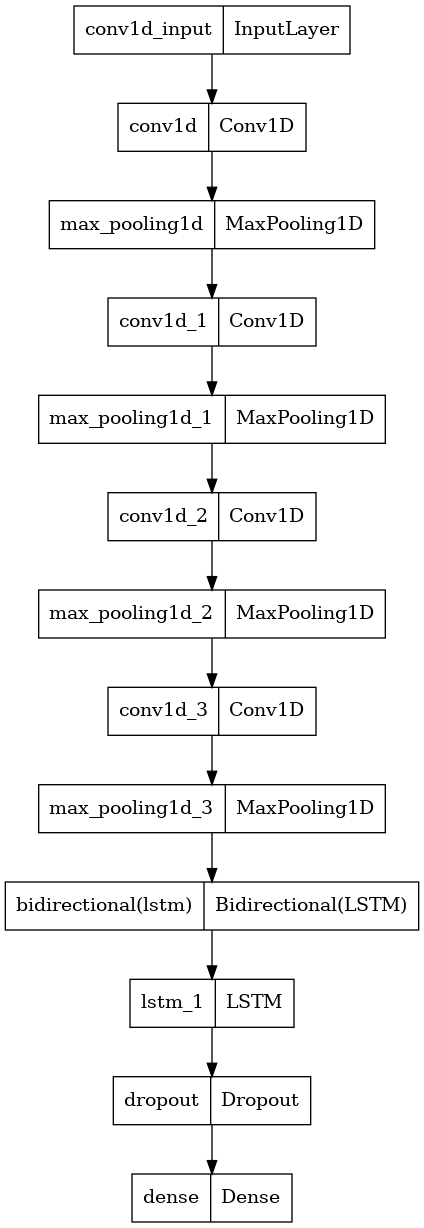

In [30]:
## model parameters
vocab_size = X_train.shape[1] # time_steps
embedding_dims =  X_train.shape[2] # number of features
noutput = y_train.shape[1]          # output lables
max_len = X_train.shape[0]         # 

model = Sequential()
#model.add(Embedding(vocab_size, embedding_dims, input_length = max_len))
model.add(Conv1D(256, kernel_size = 5, input_shape = (vocab_size, embedding_dims), activation = "relu"))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Conv1D(128, kernel_size = 5, activation = "relu"))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Conv1D(64, kernel_size = 5, activation = "relu"))
model.add(MaxPooling1D(pool_size=5, strides = 5, padding = 'same'))
model.add(Conv1D(128, kernel_size = 5, activation = "relu"))
model.add(MaxPooling1D(pool_size=5, strides = 5, padding = 'same'))
# bidirectional LSTM
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(LSTM(64, recurrent_dropout = 0.4))
model.add(Dropout(0.2))
#model.add(Flatten())
# model.add(Dense(32,activation="relu"))
model.add(Dense(noutput, activation = "softmax"))

print(model.input_shape,model.output_shape)
plot_model(model)


In [31]:
optimizer = Adam(lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,patience=2, min_lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=["accuracy"])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, 
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping,reduce_lr])

Epoch 1/100
103/103 [==============================] - 14s 71ms/step - loss: 2.6094 - accuracy: 0.1227 - val_loss: 2.5200 - val_accuracy: 0.1740 - lr: 1.0000e-04
Epoch 2/100
103/103 [==============================] - 6s 57ms/step - loss: 2.4024 - accuracy: 0.1593 - val_loss: 2.2429 - val_accuracy: 0.2106 - lr: 1.0000e-04
Epoch 3/100
103/103 [==============================] - 6s 60ms/step - loss: 2.1746 - accuracy: 0.2295 - val_loss: 2.1006 - val_accuracy: 0.2454 - lr: 1.0000e-04
Epoch 4/100
103/103 [==============================] - 6s 58ms/step - loss: 2.0451 - accuracy: 0.2613 - val_loss: 1.9803 - val_accuracy: 0.2875 - lr: 1.0000e-04
Epoch 5/100
103/103 [==============================] - 6s 62ms/step - loss: 1.9643 - accuracy: 0.2973 - val_loss: 1.9195 - val_accuracy: 0.3004 - lr: 1.0000e-04
Epoch 6/100
103/103 [==============================] - 6s 57ms/step - loss: 1.9063 - accuracy: 0.3077 - val_loss: 1.9117 - val_accuracy: 0.3077 - lr: 1.0000e-04
Epoch 7/100
103/103 [============

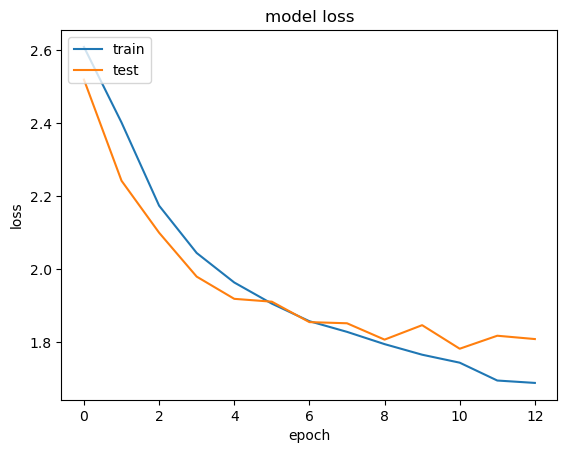

In [32]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

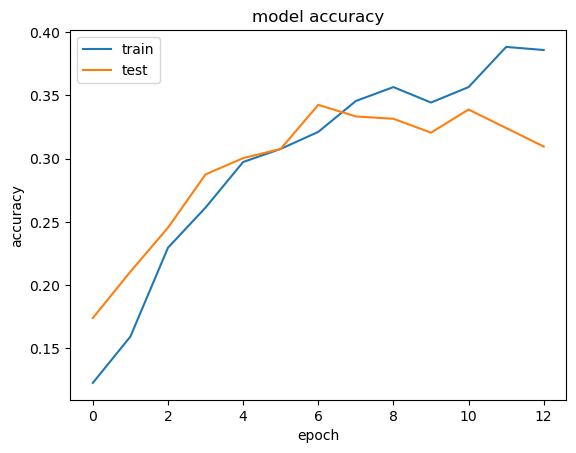

In [33]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# save model
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /kaggle/working/saved_models/Emotion_Model.h5 


In [35]:
# loading json and model architecture 
json_file = open('/kaggle/working/model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")
 
optimizer = Adam(lr=0.0001)
loaded_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 30.95%


In [36]:
preds = loaded_model.predict(X_test, batch_size=16, verbose=1)
preds=preds.argmax(axis=1)
preds.shape

35/35 [==============================] - 2s 13ms/step


(546,)

In [37]:
# preds = model.predict(X_test, batch_size=16, verbose=1)
# preds=preds.argmax(axis=1)

preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predicted_values': preds})

# actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actual_values': actual})

# combine both dataframe
finaldf = actual.join(preds)
finaldf[:20]

,actual_values,predicted_values
0,male_fear,male_fear
1,male_angry,male_neutral
2,male_disgust,male_sad
3,male_angry,male_angry
4,male_disgust,male_disgust
5,female_angry,female_angry
6,female_surprise,female_happy
7,female_happy,female_disgust
8,female_happy,female_angry
9,female_angry,female_angry


In [38]:
# save for mapping in custom examples
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predicted_values').count()

,actual_values
predicted_values,
female_angry,53
female_disgust,90
female_fear,38
female_happy,17
female_neutral,37
female_sad,20
female_surprise,24
male_angry,34
male_disgust,18


In [39]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'


## Emotion & Gender wise accuracy

we can male misprediction is greater than female misprediction


0.30952380952380953


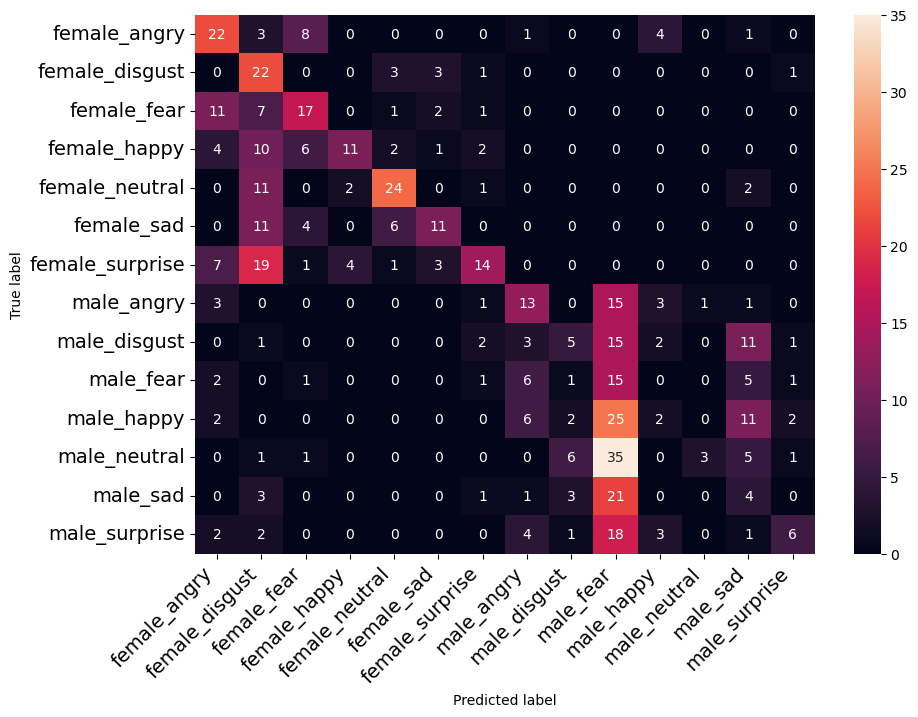

In [40]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actual_values.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actual_values, finaldf.predicted_values)
print(accuracy_score(finaldf.actual_values, finaldf.predicted_values))
print_confusion_matrix(c, class_names = classes)

Following categories are troublesome category - where the model is making mistake ,we might use some audio
augmentation to better separate these category

    Female anger & Female fear
    Female surprise & Female happy, Female disgust
    Male nutral & Male surprise,Male sad, Male happy
    Male sad vs Male happy & Male disgust

In [41]:
# Classification report 
classes = finaldf.actual_values.unique()
classes.sort()    
print(classification_report(finaldf.actual_values, finaldf.predicted_values, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.42      0.56      0.48        39
 female_disgust       0.24      0.73      0.37        30
    female_fear       0.45      0.44      0.44        39
   female_happy       0.65      0.31      0.42        36
 female_neutral       0.65      0.60      0.62        40
     female_sad       0.55      0.34      0.42        32
female_surprise       0.58      0.29      0.38        49
     male_angry       0.38      0.35      0.37        37
   male_disgust       0.28      0.12      0.17        40
      male_fear       0.10      0.47      0.17        32
     male_happy       0.14      0.04      0.06        50
   male_neutral       0.75      0.06      0.11        52
       male_sad       0.10      0.12      0.11        33
  male_surprise       0.50      0.16      0.24        37

       accuracy                           0.31       546
      macro avg       0.41      0.33      0.31       546
   weighted avg       0.43   

## Genderwise Prediction

we see most of the wrong predictions are for males which has been predicted as female

0.9413919413919414


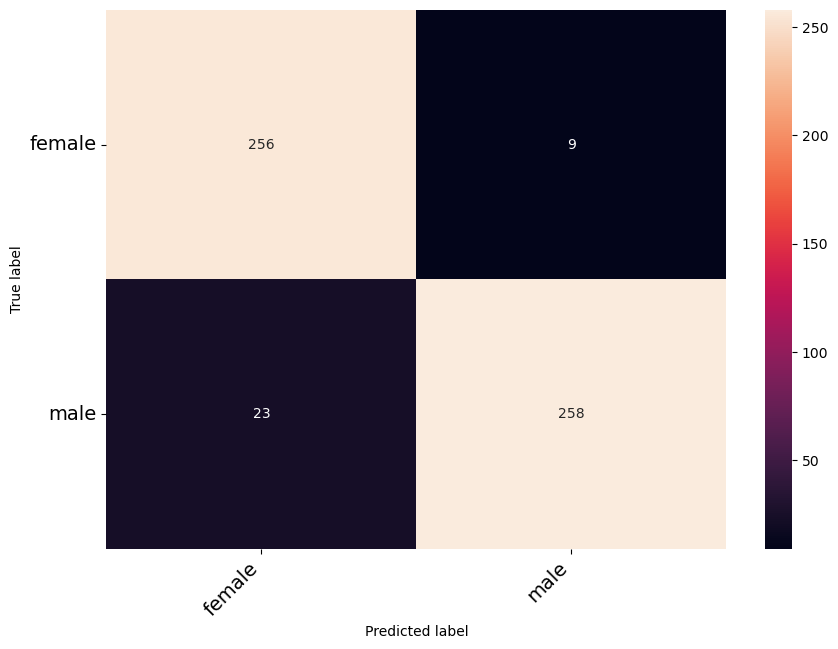

In [42]:
modidf = finaldf
modidf['actual_values'] = finaldf.actual_values.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predicted_values'] = finaldf.predicted_values.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actual_values.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actual_values, modidf.predicted_values)
print(accuracy_score(modidf.actual_values, modidf.predicted_values))
print_confusion_matrix(c, class_names = classes)

### Testing on custom audio

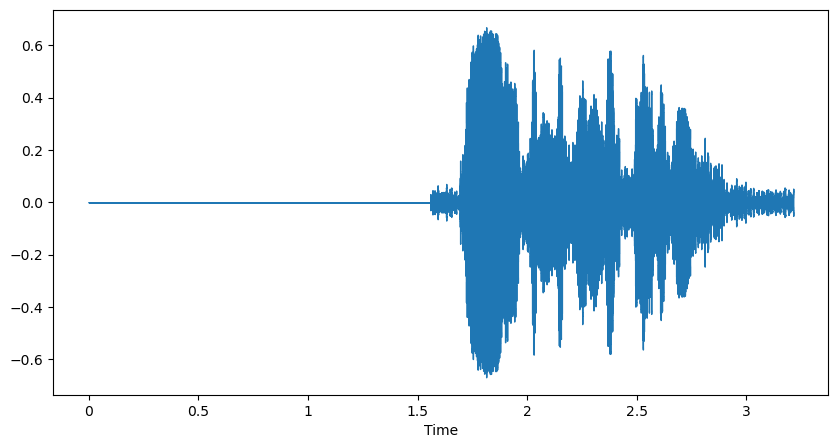

In [43]:
data, sampling_rate = librosa.load('/kaggle/input/khala-hobe-ki/khala_hobe_2.wav')

plt.figure(figsize=(10, 5))
librosa.display.waveshow(data, sr=sampling_rate)
Audio('/kaggle/input/khala-hobe-ki/khala_hobe_2.wav')

In [44]:
# loading json and model architecture 
json_file = open('/kaggle/input/ers-model/model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/kaggle/input/ers-model/Emotion_Model.h5")
print("Loaded model from disk")

# the optimiser
optimizer = Adam(lr=0.0001)
loaded_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Loaded model from disk


In [45]:
X, sample_rate = librosa.load('/kaggle/input/khala-hobe-ki/khala_hobe_2.wav',duration=2.5,sr=44100)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
newdf = pd.DataFrame(data=mfccs)
X_test.shape,newdf.shape

((546, 216, 1), (216, 1))

In [46]:
# newdf= np.expand_dims(newdf, axis=2)

In [47]:
newpred = loaded_model.predict(newdf, batch_size=16, verbose=1)
newpred.shape

14/14 [==============================] - 1s 3ms/step


(216, 14)

In [48]:
filename = '/kaggle/input/emotion-labels/labels'
infile = open(filename,'rb')
lb = pickle.load(infile)
infile.close()

# Get the final predicted label
final = newpred.argmax(axis=1)
final = final.astype(int).flatten()
final = (lb.inverse_transform((final)))
#print(final) #emo(final) #gender(final) 


In [49]:
mp = Counter(final)
predict_custom = pd.DataFrame(list(mp.keys()),columns={"Emotion"})
predict_custom["Confidance"]= list(mp.values())
predict_custom["Confidance"]= round(predict_custom["Confidance"]*100/np.sum(predict_custom["Confidance"]),2)
predict_custom=predict_custom.sort_values(by=["Confidance"],ascending=False)
predict_custom

,Emotion,Confidance
0,male_surprise,62.04
1,male_neutral,16.67
2,male_disgust,11.57
3,male_sad,6.02
5,male_fear,3.24
4,female_disgust,0.46


In [50]:
##